In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm  

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Set all random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
num_class=7
img_rows,img_cols=48,48 #image size
batch_size=16 #decrease from 32 to 16 back to 32

In [4]:
# For GPU determinism (if using GPU)
tf.config.experimental.enable_op_determinism()

In [5]:
# Regularization strength (tunable)
kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4) #new, l1_l2 regularisation

In [6]:
train_data=r'C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013 (USED)\train'

validation_data=r'C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013 (USED)\test'

In [7]:
# Get the list of folders in the directory as classes
classes=os.listdir(train_data+'/')
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
def get_class_distribution(dataset_path):
    class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder)))
                    for folder in os.listdir(dataset_path)
                    if os.path.isdir(os.path.join(dataset_path, folder))}
    return class_counts


In [9]:
def plot_class_distribution(class_counts, title="Class Distribution"):
    df = pd.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Emotion', y='Count', data=df)
    plt.title(title)
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


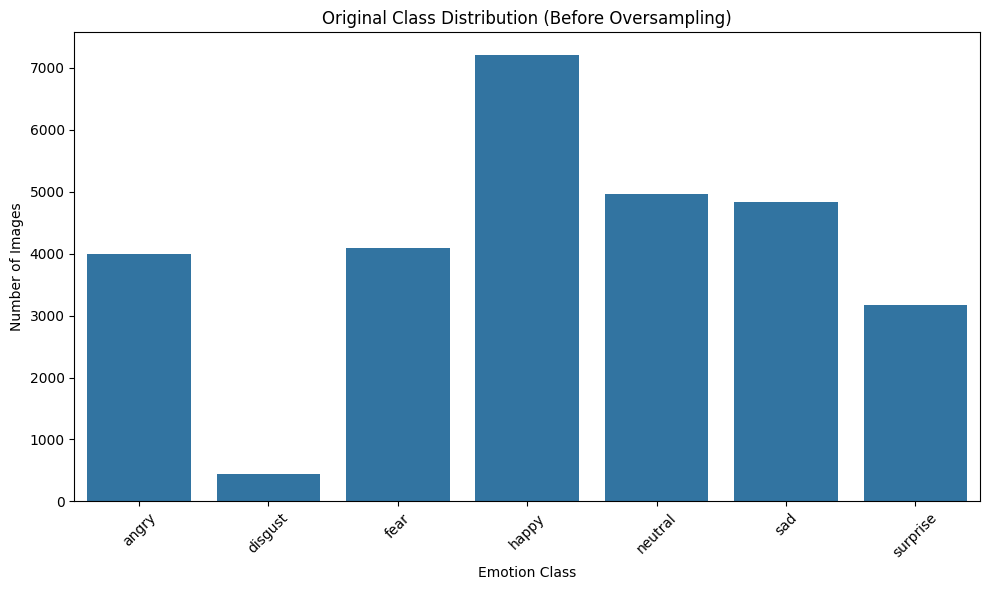

In [10]:
original_counts = get_class_distribution(train_data)
plot_class_distribution(original_counts, title="Original Class Distribution (Before Oversampling)")


In [11]:


OVERSAMPLED_TRAIN_PATH = r'C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\FER-2013 (USED)\oversampled_train'
TARGET_LENGTH = 10000  # Set to max class size or any desired balance

def oversample_dataset(train_dir=train_data, oversampled_dir=OVERSAMPLED_TRAIN_PATH, target_length=TARGET_LENGTH):
    if not os.path.exists(oversampled_dir):
        os.makedirs(oversampled_dir)

    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        num_images = len(images)
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        dest_dir = os.path.join(oversampled_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)

        # Duplicate all images num_duplicates times
        for i in range(num_duplicates):
            for image_name in images:
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(dest_dir, f"{i}_{image_name}")
                Image.open(src_path).save(dst_path)

        # Add remainder images
        for i, image_name in enumerate(images[:remainder]):
            src_path = os.path.join(class_path, image_name)
            dst_path = os.path.join(dest_dir, f"{num_duplicates}_{i}_{image_name}")
            Image.open(src_path).save(dst_path)

#oversample_dataset()


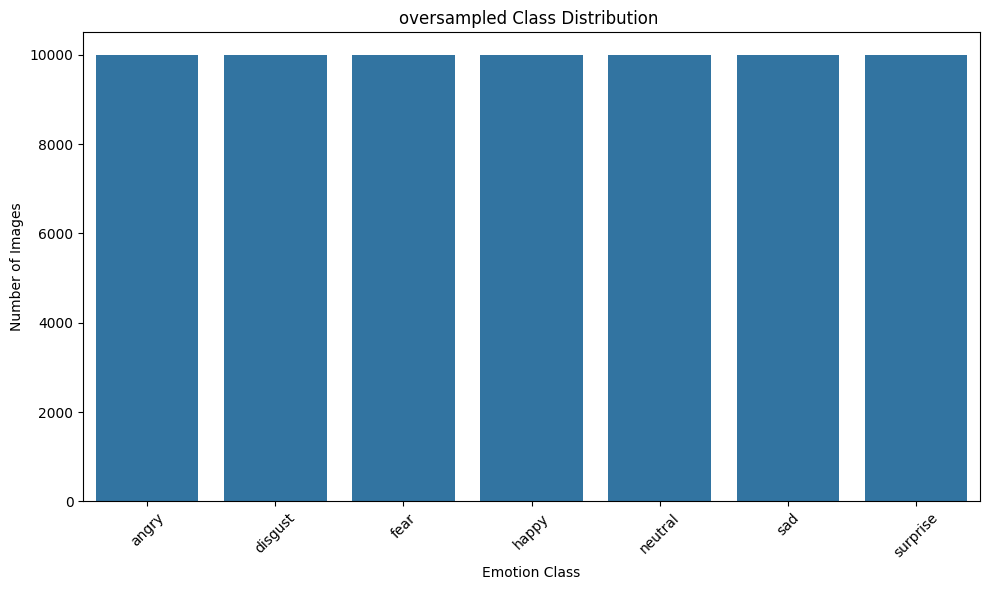

In [12]:
original_counts = get_class_distribution(OVERSAMPLED_TRAIN_PATH)
plot_class_distribution(original_counts, title="oversampled Class Distribution ")

In [13]:
#image data generator section

#here we generated some images 

train_dataGen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,           # Increase from 10 to 15
    shear_range=0.10,            # Increase from 0.1 to 0.2 back to 0.15
    zoom_range=0.10,             # Increase from 0.1 to 0.2 back to 0.15 back to 0.1
    width_shift_range=0.10,      # Increase from 0.1 to 0.2 back to 0.15
    height_shift_range=0.10,     # Increase from 0.1 to 0.2 back to 0.15
    horizontal_flip=True
    #brightness_range=[0.8, 1.2], # ADD: brightness variation- remove for now
    #channel_shift_range=0.1      # ADD: slight channel shift remove for now 
)


validation_dataGen=ImageDataGenerator(rescale=1./255)

#give to model to train-train parameters

train_generator = train_dataGen.flow_from_directory(
  OVERSAMPLED_TRAIN_PATH,
  color_mode='grayscale',
  target_size=(img_rows,img_cols) , 
  batch_size=batch_size,
  class_mode='categorical', 
  shuffle=True
   )

#new - add class weighs

from sklearn.utils.class_weight import compute_class_weight

labels = train_generator.classes  # Numpy array of class indices
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

#end of new

#validation parameters
validation_generator = validation_dataGen.flow_from_directory(validation_data,
color_mode='grayscale',
 target_size=(img_rows,img_cols) , 
 batch_size=batch_size,
   class_mode='categorical', 
   shuffle=True
   )

Found 70000 images belonging to 7 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0)}
Found 7178 images belonging to 7 classes.


In [14]:
model= Sequential()

#change, block 1-4, increase dropout from 0.2 to 0.3 0.2
#change, block 5-6, decrease dropout from 0.5 to 0.4 0.3


# Block 1 - Deeper feature extraction
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer, input_shape=(img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(SpatialDropout2D(0.25))


# Block 2 - Increased capacity
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(SpatialDropout2D(0.25))


# Block 3 - Higher-level features
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))
model.add(SpatialDropout2D(0.3))


# Block 4 - Complex pattern recognition
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# Block 5 - Additional deep features
model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                 kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Dropout(0.4))


# Global Average Pooling - reduces overfitting compared to Flatten
model.add(GlobalAveragePooling2D())


# Fully Connected Dense Layers
model.add(Dense(256, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# Output Layer
model.add(Dense(num_class, kernel_initializer='he_normal'))
model.add(Activation('softmax'))


print(model.summary())

c:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\CodePython\keras_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 24, 24, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,672,007 (21.64 MB)

 Trainable params: 5,666,311 (21.62 MB)

 Non-trainable params: 5,696 (22.25 KB)

None


In [15]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(r'C:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\Emotion_little_vgg.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=7, #increase from 3
                         verbose=1,
                         restore_best_weights=True
                         )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5, #change from 0.2
                            patience=5, #increase from 3
                            verbose=1,
                            min_delta=0.0001)

callbacks = [earlystop,reduce_lr]

optimizer = Adam(learning_rate=0.0001 , clipnorm=1.0)  # Reduced from 0.001

In [16]:
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'precision', 'recall'])

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
epochs=60 #how many times to train same image, model will go 25 times in every folder #increase from 25


history=model.fit(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size,
                 class_weight=class_weights_dict )

model.save('Emotion_model_20.h5')

Epoch 1/60


c:\Users\nourm\OneDrive\Desktop\PROJECTS\UNITY MODEL PROJECT\CodePython\keras_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 540s 121ms/step - accuracy: 0.1573 - loss: 4.2809 - precision: 0.1629 - recall: 0.0444 - val_accuracy: 0.1903 - val_loss: 3.4763 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/60
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 520s 119ms/step - accuracy: 0.1875 - loss: 3.2793 - precision: 0.2900 - recall: 0.0237 - val_accuracy: 0.2107 - val_loss: 2.7575 - val_precision: 0.5239 - val_recall: 0.0566 - learning_rate: 1.0000e-04
Epoch 3/60
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 695s 159ms/step - accuracy: 0.2858 - loss: 2.5855 - precision: 0.5495 - recall: 0.0703 - val_accuracy: 0.4106 - val_loss: 2.1851 - val_precision: 0.7828 - val_recall: 0.1332 - learning_rate: 1.0000e-04
Epoch 4/60
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 535s 122ms/step - accuracy: 0.3897 - loss: 2.2083 - precision: 0.6424 - recall: 0.1616 - val_accuracy: 0.4508 - val_loss: 2.0260 - val_precision: 0.6207 - val_recall: 0.2694 - learning_rate: 1.0000e-04
Epoch 5/60
4375/4375 ━━━━━━